# Getting started with `sbi`

Note, you can find the original version of this notebook at [https://github.com/sbi-dev/sbi/blob/main/tutorials/00_getting_started.ipynb](https://github.com/sbi-dev/sbi/blob/main/tutorials/00_getting_started.ipynb) in the `sbi` repository.

In [1]:
import torch

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference.base import infer
from sbi.inference.nspe.nspe import NSPE

In [2]:
sigma_min = 1e-2
mean_fn = lambda x_source, x_target, t: (1-t)*x_source + t * x_target
std_fn = lambda x_source, x_target, t: torch.sqrt(2*t * (1-t))


In [3]:

from torch import nn

#from sbi.neural_nets.vf_estimators.flow_estimator import FlowMachtingEstimator


In [4]:
import numpy as np


class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""

    def __init__(self, embed_dim, scale=30.0):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class ScoreNet(nn.Module):
    def __init__(self, input_dim, condition_dim):
        super().__init__()
        self.input_dim = input_dim
        self.condition_dim = condition_dim
        self.time_embed_dim = 100
        self.time_embed = GaussianFourierProjection(self.time_embed_dim)
        self.num_layers = 5
        self.hidden_dim = 100
        self.linear1 = nn.Linear(self.input_dim + self.condition_dim, self.hidden_dim)
        self.dense = nn.Sequential(
            nn.Linear(self.hidden_dim + self.time_embed_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.input_dim)
        )

    def forward(self, input, condition, t):
        t = t.unsqueeze(-1)
        input_and_condition = torch.cat([input, condition], dim=-1)
        h_x = self.linear1(input_and_condition)
        time_embed = self.time_embed(t)


        h = torch.cat([h_x, time_embed], dim=-1)
        out = self.dense(h)

        return out

In [5]:
from sbi.neural_nets.vf_estimators.score_estimator import VPScoreEstimator


def build_score_estimator(thetas, xs):
    input_dim = xs.shape[-1]
    condition_dim = thetas.shape[-1]
    score_net = ScoreNet(input_dim, condition_dim)

    beta_max = 10.
    beta_min = 0.01

    def weight_fn(t):
        return torch.clip(1-torch.exp(-0.5 * (beta_max - beta_min) * t**2 - beta_min * t) ,1e-4, None)

    estimator = VPScoreEstimator(score_net, (condition_dim,), weight_fn=weight_fn, beta_min=beta_min, beta_max=beta_max)

    return estimator


In [6]:
from sbi.neural_nets.vector_field import build_score_estimator


In [7]:
infer = NSPE(score_estimator=lambda x,y: build_score_estimator(x,y, hidden_features=100, beta_min=0.01, beta_max=10., weight_fn="max_likelihood"))

In [16]:
infer = NSPE(hidden_features=100, beta_min=0.01, beta_max=10., weight_fn="max_likelihood")

In [17]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

def simulator(parameter_set):
    return 1.0 + parameter_set + torch.randn(parameter_set.shape) * 0.1

thetas = prior.sample((10000,))
xs = simulator(thetas)

In [18]:
infer.append_simulations(thetas, xs)
score_net = infer.train(training_batch_size=100, stop_after_epochs=200)

 Neural network successfully converged after 201 epochs.

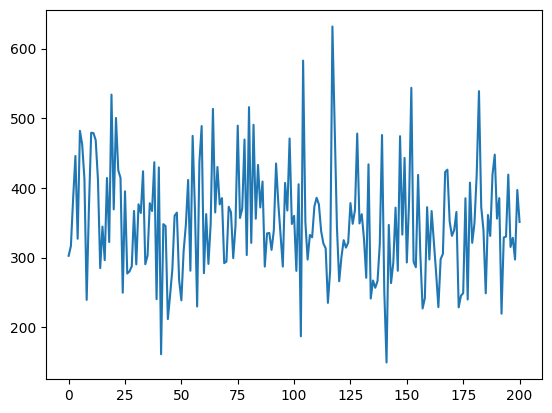

In [11]:
import matplotlib.pyplot as plt

plt.plot(infer._summary["training_loss"])

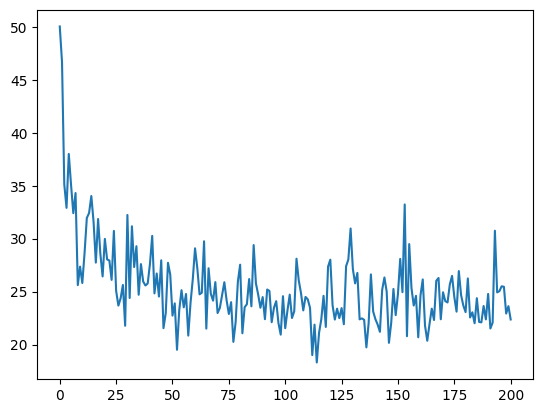

In [19]:
plt.plot(infer._summary["training_loss"])

In [20]:
posterior = infer.build_posterior()

In [21]:
x_o = xs[0]
theta_o = thetas[0]

In [22]:
samples = posterior.sample((1000,), x=x_o.unsqueeze(0))

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

(<Figure size 1000x1000 with 9 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='dim 3'>]], dtype=object))

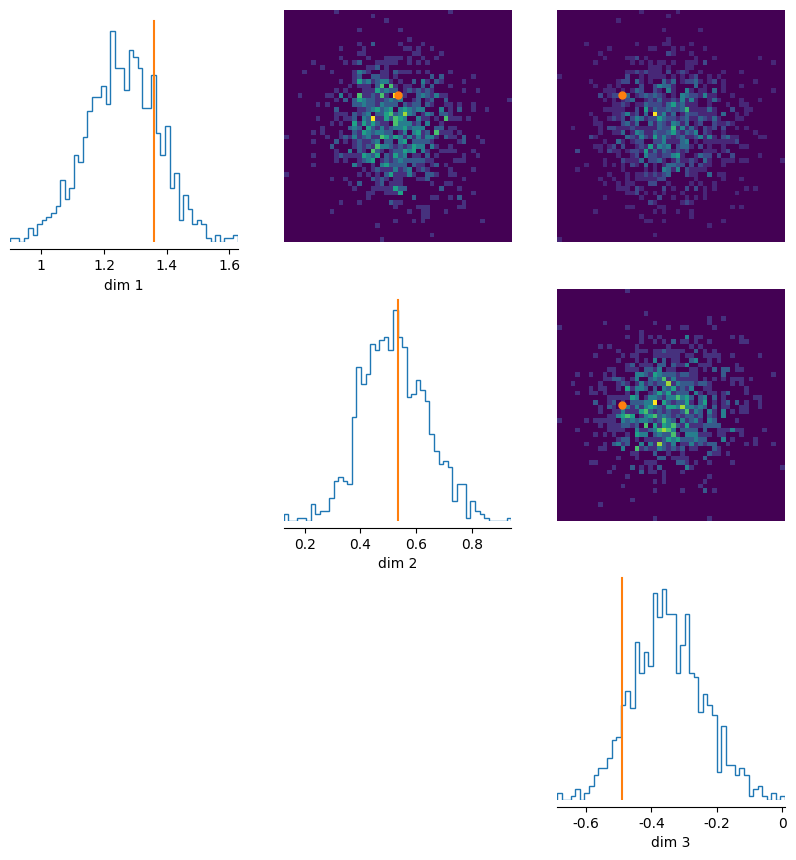

In [23]:
from sbi.analysis import pairplot

pairplot(samples[:,0].detach(), points=theta_o)

In [17]:
torch.linspace(1.,1e-3, 1000)

tensor([1.0000, 0.9990, 0.9980, 0.9970, 0.9960, 0.9950, 0.9940, 0.9930, 0.9920,
        0.9910, 0.9900, 0.9890, 0.9880, 0.9870, 0.9860, 0.9850, 0.9840, 0.9830,
        0.9820, 0.9810, 0.9800, 0.9790, 0.9780, 0.9770, 0.9760, 0.9750, 0.9740,
        0.9730, 0.9720, 0.9710, 0.9700, 0.9690, 0.9680, 0.9670, 0.9660, 0.9650,
        0.9640, 0.9630, 0.9620, 0.9610, 0.9600, 0.9590, 0.9580, 0.9570, 0.9560,
        0.9550, 0.9540, 0.9530, 0.9520, 0.9510, 0.9500, 0.9490, 0.9480, 0.9470,
        0.9460, 0.9450, 0.9440, 0.9430, 0.9420, 0.9410, 0.9400, 0.9390, 0.9380,
        0.9370, 0.9360, 0.9350, 0.9340, 0.9330, 0.9320, 0.9310, 0.9300, 0.9290,
        0.9280, 0.9270, 0.9260, 0.9250, 0.9240, 0.9230, 0.9220, 0.9210, 0.9200,
        0.9190, 0.9180, 0.9170, 0.9160, 0.9150, 0.9140, 0.9130, 0.9120, 0.9110,
        0.9100, 0.9090, 0.9080, 0.9070, 0.9060, 0.9050, 0.9040, 0.9030, 0.9020,
        0.9010, 0.9000, 0.8990, 0.8980, 0.8970, 0.8960, 0.8950, 0.8940, 0.8930,
        0.8920, 0.8910, 0.8900, 0.8890, 

In [59]:
posterior.potential_fn.x_o.shape[0]

1

In [63]:
posterior.score_estimator(samples_0, torch.zeros((1,1,3)), torch.ones((1,))*0.5)

torch.Size([1000, 3]) torch.Size([1, 1, 3]) torch.Size([1])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])


tensor([[-1.2607, -1.2893, -1.2307],
        [-1.1254, -1.6394, -1.0701],
        [-1.0427, -1.6291, -0.9877],
        ...,
        [-0.9162, -1.7545, -1.0646],
        [-0.9360, -1.5651, -1.2981],
        [-1.0903, -1.5253, -1.1634]], grad_fn=<ViewBackward0>)

In [64]:
posterior.potential_fn(samples_0, torch.ones((1,)))

torch.Size([1000, 3]) torch.Size([1, 1, 3]) torch.Size([1])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])


tensor([[-1.1459, -1.7442, -0.9893],
        [-1.0084, -2.0569, -0.7771],
        [-0.8786, -1.9754, -0.7941],
        ...,
        [-0.7428, -2.0983, -1.0411],
        [-0.6926, -1.9533, -1.4670],
        [-0.9384, -1.9237, -1.0371]], grad_fn=<ViewBackward0>)

In [34]:
nn.Linear(10,2)(torch.ones((100,100,10))).shape

torch.Size([100, 100, 2])

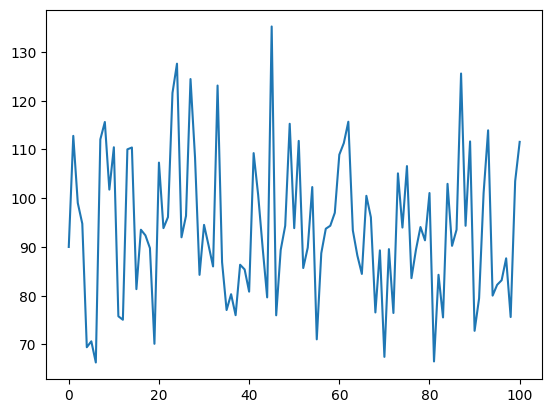

In [10]:
import matplotlib.pyplot as plt

plt.plot(infer._summary["training_loss"])

In [47]:
x_o = xs[0][None]
x_o = torch.repeat_interleave(x_o, 1000, dim=0)
theta_o = thetas[0]
samples_0 = torch.randn(1000, 3)
dt = torch.tensor(0.01)
num_steps = int(1/dt)
for i in range(num_steps):
    t = 1-i * dt * torch.ones(1000)

    score = score_net(samples_0, x_o, t)
    f = score_net.drift_fn(samples_0, t)
    g = score_net.diffusion_fn(samples_0,t)
    f_backward = f - g**2 * score

    samples_0 = samples_0 - f_backward * dt + g * torch.randn(1000, 3) * torch.sqrt(dt)


torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])
torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size(

In [48]:
samples_0

tensor([[1.1103, 1.3919, 1.1450],
        [0.9817, 1.7235, 0.8675],
        [0.7646, 1.5477, 0.9043],
        ...,
        [0.6277, 1.6801, 1.0959],
        [0.6350, 1.5305, 1.4947],
        [0.8695, 1.5316, 1.1436]], grad_fn=<AddBackward0>)

In [49]:
samples

tensor([[[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        ...,

        [[nan, nan, nan]],

        [[nan, nan, nan]],

        [[nan, nan, nan]]], grad_fn=<AddBackward0>)

(<Figure size 1000x1000 with 9 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='dim 3'>]], dtype=object))

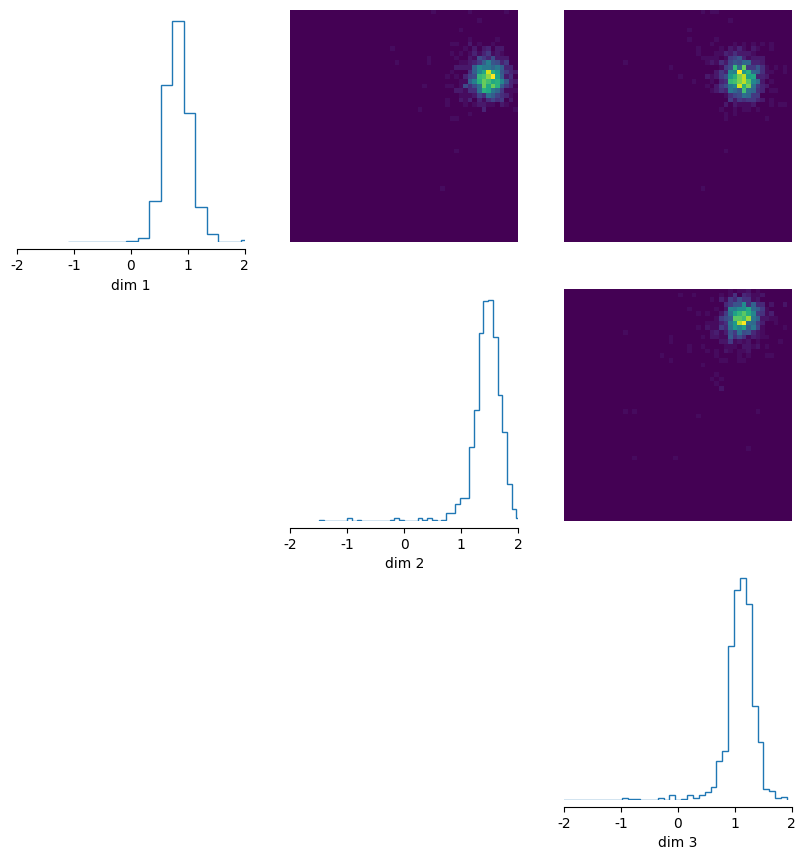

In [50]:
from sbi.analysis import pairplot

pairplot(samples_0.detach(), limits=[[-2, 2], [-2, 2], [-2, 2]])

tensor(463023.4375, grad_fn=<MeanBackward0>)
tensor(379099.1875, grad_fn=<MeanBackward0>)
tensor(544390.6250, grad_fn=<MeanBackward0>)
tensor(289612.7812, grad_fn=<MeanBackward0>)
tensor(459229.9375, grad_fn=<MeanBackward0>)
tensor(613868.9375, grad_fn=<MeanBackward0>)
tensor(636685.8125, grad_fn=<MeanBackward0>)
tensor(131260.2656, grad_fn=<MeanBackward0>)
tensor(910974.6250, grad_fn=<MeanBackward0>)
 Training neural network. Epochs trained: 1tensor(942286.2500, grad_fn=<MeanBackward0>)
tensor(930910.2500, grad_fn=<MeanBackward0>)
tensor(13642.5098, grad_fn=<MeanBackward0>)
tensor(409363.8125, grad_fn=<MeanBackward0>)
tensor(234357.7812, grad_fn=<MeanBackward0>)
tensor(466524.8438, grad_fn=<MeanBackward0>)
tensor(773847.1250, grad_fn=<MeanBackward0>)
tensor(351540.7188, grad_fn=<MeanBackward0>)
tensor(462950.0312, grad_fn=<MeanBackward0>)
 Training neural network. Epochs trained: 2tensor(701000.9375, grad_fn=<MeanBackward0>)
tensor(131381.3750, grad_fn=<MeanBackward0>)
tensor(584048.,

In [29]:
x_o

NameError: name 'x_o' is not defined

In [27]:
score_net(thetas, xs, torch.ones((10000,)))

tensor([[-0.0185, -0.0048,  0.0214],
        [-0.0449, -0.0363,  0.1099],
        [-0.0292, -0.0472,  0.0714],
        ...,
        [ 0.0809,  0.0896, -0.0205],
        [-0.0195,  0.0580,  0.1442],
        [-0.0595, -0.0405,  0.1302]], grad_fn=<DivBackward0>)

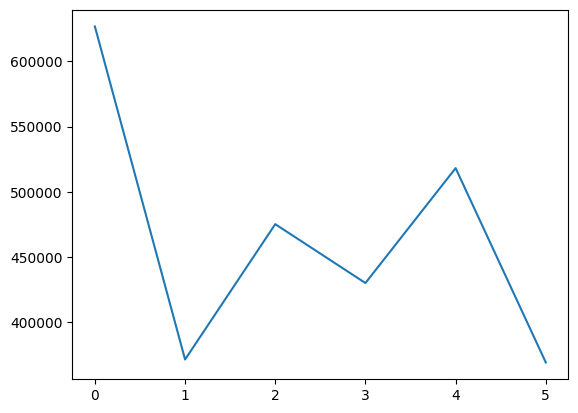

In [12]:
import matplotlib.pyplot as plt

plt.plot(infer._summary["training_loss"])

In [13]:
posterior = infer.build_posterior()

In [14]:
posterior.score_estimator.diffusion_fn(torch.rand(100))

tensor([[3.5287e-01],
        [6.7046e-04],
        [1.0649e-02],
        [2.1032e-03],
        [1.3694e+00],
        [1.3809e+00],
        [1.1410e-01],
        [4.9364e-03],
        [1.6426e-03],
        [1.2419e+00],
        [5.6967e-01],
        [4.4544e-01],
        [1.4020e-03],
        [1.9546e-01],
        [2.5252e-01],
        [3.6509e-03],
        [1.3396e+00],
        [8.6075e-02],
        [9.4520e-04],
        [1.2690e+00],
        [6.3045e-01],
        [3.1573e-01],
        [1.0924e+00],
        [8.1535e-01],
        [8.0592e-04],
        [4.0111e-04],
        [2.6344e-03],
        [6.4383e-01],
        [1.3102e+00],
        [3.4567e-04],
        [8.8355e-01],
        [2.8867e-02],
        [5.6813e-03],
        [1.2818e+00],
        [8.8619e-03],
        [8.1151e-01],
        [1.0029e-03],
        [2.3846e-04],
        [7.5622e-02],
        [1.2585e+00],
        [1.2336e+00],
        [3.5650e-02],
        [7.8198e-01],
        [8.5359e-03],
        [1.0325e+00],
        [2

In [15]:
samples = posterior.sample((1000,), x=torch.tensor([1.0, 1.0, 1.0]))

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1000, 3]) torch.Size([1000, 3]) torch.Size([1000])


IndexError: tuple index out of range

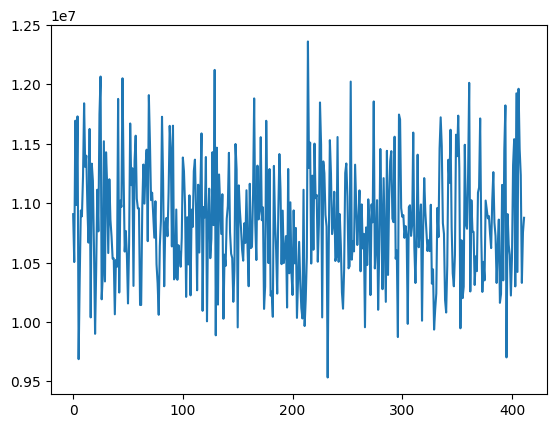

In [17]:
import matplotlib.pyplot as plt

plt.plot(infer._summary["training_loss"])

In [5]:
times = torch.rand((100,1))
xs_source = torch.rand((100,2))
xs_target = torch.rand((100,2))
with torch.enable_grad():
    times = times.clone().requires_grad_(True)
    m_t = mean_fn(xs_source, xs_target, times)
    grad = torch.autograd.grad(m_t, times, grad_outputs=torch.ones_like(m_t), create_graph=True)[0]

In [190]:
from torch import Tensor


class OTFlowMatchingEstimator(FlowMachtingEstimator):

    def __init__(self, net, condition_shape, sigma_min=1e-5):
        super().__init__(net, condition_shape)
        self.sigma_min = sigma_min

    def mean_fn(self, xs_source: Tensor, xs_target: Tensor, times: Tensor):
        return  times*xs_target

    def std_fn(self, xs_source: Tensor, xs_target: Tensor, times: Tensor):
        return  (1 - (1-self.sigma_min)*times)



In [ ]:
# Variance preserving conditional flow matching
sigma = 1e-4
mean_fn = lambda x_source, x_target, t: jnp.cos(jnp.pi / 2*t)*x_source + jnp.sin(jnp.pi / 2*t)*x_target
std_fn = lambda x_source, x_target, t: jnp.array(sigma)

In [145]:

class VPFlow(FlowMachtingEstimator):


    def mean_fn(self, xs_source: Tensor, xs_target: Tensor, times: Tensor):
        return torch.cos(np.pi / 2*times)*xs_source + torch.sin(np.pi / 2*times)*xs_target

    def std_fn(self, xs_source: Tensor, xs_target: Tensor, times: Tensor):
        return torch.tensor([1e-5])

    def std_fn_grad(self, xs_source: Tensor, xs_target: Tensor, times: Tensor) -> Tensor:
        return torch.tensor([0.])


In [191]:
flow_estimator = OTFlowMatchingEstimator(ScoreNet(3,3), (3,))

In [192]:
flow_estimator.std_fn_grad(torch.zeros((10,2)),torch.ones((10,2)),torch.zeros((10,1))+ 1e-4)

tensor([[-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000]])

In [193]:
def build_estimator(thetas,xs):
    input_dim = thetas.shape[-1]
    condition_dim = xs.shape[-1]
    estimator = OTFlowMatchingEstimator(ScoreNet(input_dim,condition_dim), (condition_dim,))
    return estimator


In [194]:
from sbi.inference import SNPE

In [195]:
inference = SNPE(density_estimator=build_estimator, show_progress_bars=True)

In [196]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

def simulator(parameter_set):
    return 1.0 + parameter_set + torch.randn(parameter_set.shape) * 0.1

thetas = prior.sample((10000,))
xs = simulator(thetas)

In [197]:
inference = inference.append_simulations(thetas, xs)

In [198]:
inference._summary

{'epochs_trained': [],
 'best_validation_loss': [],
 'validation_loss': [],
 'training_loss': [],
 'epoch_durations_sec': []}

In [199]:
score_net = inference.train(training_batch_size=1000,stop_after_epochs=500)

 Neural network successfully converged after 1495 epochs.

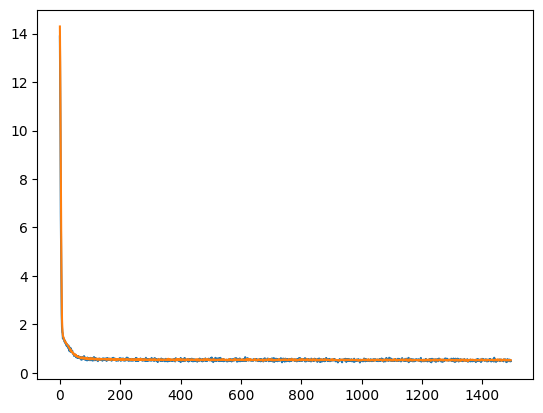

In [200]:
import matplotlib.pyplot as plt

plt.plot(inference._summary["validation_loss"])
plt.plot(inference._summary["training_loss"])

In [182]:
samples_0 = score_net.source_distribution.sample((1000,3))

In [183]:
theta_o = prior.sample((1,))
x_o = simulator(theta_o)

In [184]:
x_os = torch.repeat_interleave(x_o, 1000, dim=0)

def drift(x, t):
    return score_net(x, condition = x_os, time=t* torch.ones((1000,1)))

In [185]:
import torch


def euler(f, y0, t):
    """
    Euler's method for solving ODEs.

    Parameters:
    f : function
        Function that defines the ODE.
    y0 : torch.Tensor
        Initial condition.
    t : torch.Tensor
        1D tensor of t values where the ODE should be solved.

    Returns:
    torch.Tensor
        1D tensor of y values where the ODE has been solved.
    """
    y = torch.zeros(t.shape[0], *y0.shape, dtype=y0.dtype, device=y0.device)
    y[0] = y0

    for i in range(1, t.shape[0]):
        dt = t[i] - t[i-1]
        y[i] = y[i-1] + f(y[i-1], t[i-1]) * dt

    return y

In [186]:
samples = euler(drift, samples_0, torch.linspace(0, 1, 100))

In [187]:
from sbi.analysis import pairplot

(<Figure size 500x500 with 9 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='dim 3'>]], dtype=object))

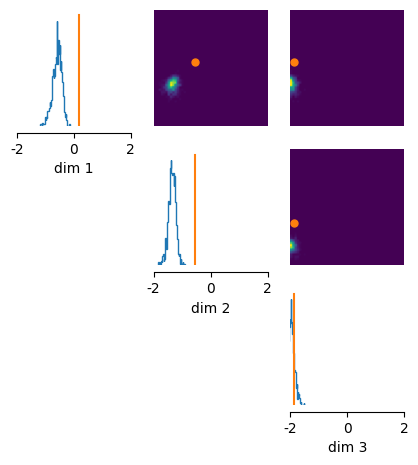

In [188]:
pairplot(samples[-1].detach(), limits=[[-2, 2], [-2, 2], [-2, 2]], points=theta_o, figsize=(5, 5))

(<Figure size 1000x1000 with 9 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='dim 3'>]], dtype=object))

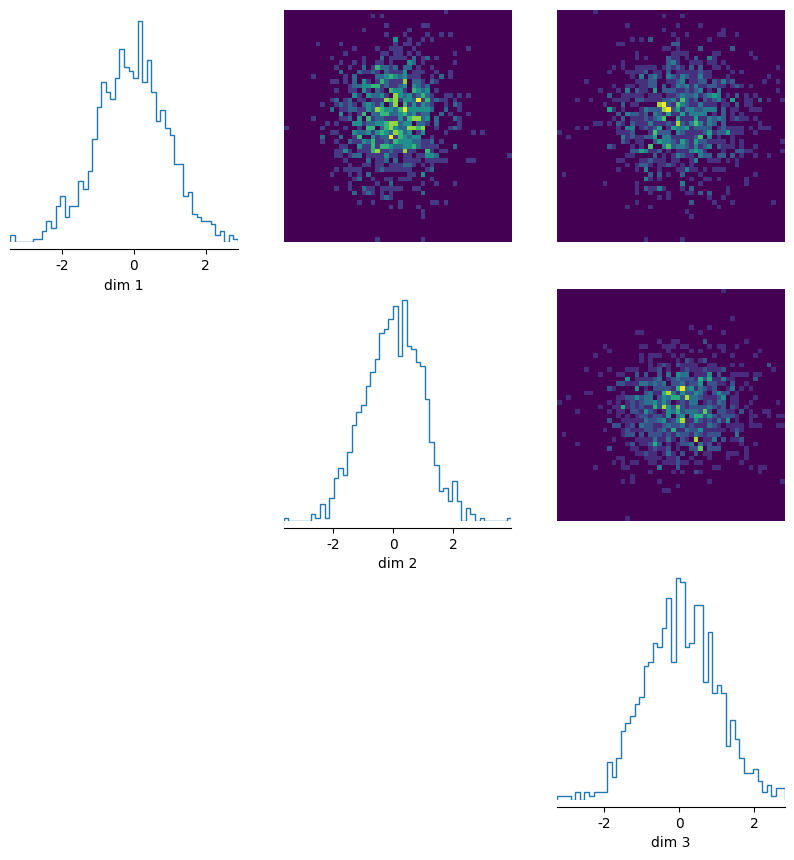

In [ ]:
from sbi.analysis import pairplot

pairplot(samples_t.detach())

## Running the inference procedure

`sbi` provides a simple interface to run state-of-the-art algorithms for simulation-based inference.

For inference, you need to provide two ingredients:

1) a prior distribution that allows to sample parameter sets.  
2) a simulator that takes parameter sets and produces simulation outputs.

For example, we can have a 3-dimensional parameter space with a uniform prior between [-1,1] and a simple simulator that for the sake of example adds 1.0 and some Gaussian noise to the parameter set:

In [ ]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

def simulator(parameter_set):
    return 1.0 + parameter_set + torch.randn(parameter_set.shape) * 0.1

`sbi` can then run inference:

In [ ]:
# Other methods are "SNLE" or "SNRE".
posterior = infer(simulator, prior, method="SNPE", num_simulations=2000)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 80 epochs.

Let's say we have made some observation $x$:

In [ ]:
observation = torch.zeros(3)

 Given this observation, we can then sample from the posterior $p(\theta|x)$, evaluate its log-probability, or plot it.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

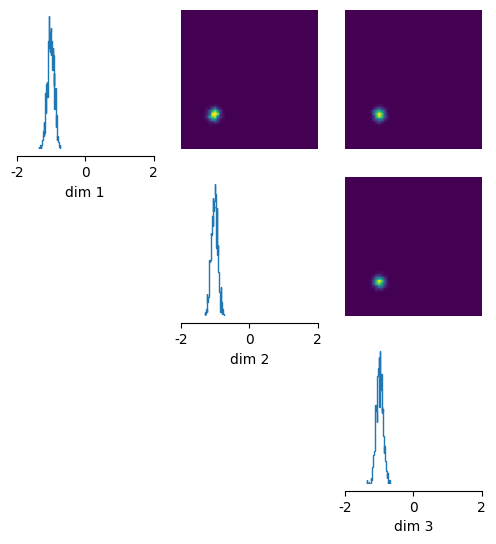

In [ ]:

samples2 = posterior.sample((1000,), x=observation)
_ = analysis.pairplot([samples2], limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6))

## Next steps

The single-line interface described above provides an easy entry for using `sbi`. However, on almost any real-world problem that goes beyond a simple demonstration, we strongly recommend using the [flexible interface](https://sbi-dev.github.io/sbi/tutorial/02_flexible_interface/).